在CMIP6中，你可以选择以下四个代表性浓度路径（SSP）情景，这四个情景涵盖了从相对温和的气候变化到极端气候变化的各种可能性：

SSP1-2.6：这是一个相对温和的情景，假设全球社会将采取积极的气候变化缓解措施，以实现低碳经济。在这个情景中，温室气体的排放将在本世纪中叶达到峰值，然后逐渐减少。

SSP2-4.5：这是一个中等的情景，假设全球社会将采取一些气候变化缓解措施，但不足以阻止气候变化的持续发展。在这个情景中，温室气体的排放将在本世纪末达到峰值。

SSP3-7.0：这是一个比较悲观的情景，假设全球社会在应对气候变化方面的行动相对较少。在这个情景中，温室气体的排放将在本世纪末仍然保持在较高水平。

SSP5-8.5：这是一个极端的情景，假设全球社会将继续依赖化石燃料，几乎不采取任何气候变化缓解措施。在这个情景中，温室气体的排放将在本世纪末达到极高水平。

选择这四个情景，可以帮助你理解在不同的气候变化情景下，气候系统可能会发生什么样的变化。

为了研究方便，本项目采用了SSP2-4.5、SSP5-8.5两种气候变化情景。

In [1]:
from netCDF4 import Dataset
import xarray as xr
import os
import numpy as np
import pandas as pd
import pickle
from scipy import stats

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# NC文件处理

## 地理信息

深圳宝安区 lat: 22.6, 113.9

苏州工业园区 lat: 31.3, 120.7

## 提取不同情景下的数据

In [4]:
suzhou_lat = 31.3
suzhou_lon = 120.7

folder = '../data/raw/CMIP6/'

# 获取文件夹下的所有文件
files = os.listdir(folder)

# 使用列表解析来获取所有以.nc结尾的文件
nc_files = [file for file in files if file.endswith('.nc')]

# 初始化空的字典，用于存储数据
# 创建一个空字典，用于存储数据
data_dict = {}

for nc_file in nc_files:
    nc_file_datasets = Dataset(folder + nc_file) 

    # 获取经纬度变量
    lat = nc_file_datasets.variables['lat'][:]
    lon = nc_file_datasets.variables['lon'][:]

    # 找到最接近指定经纬度的索引
    lat_idx = np.abs(lat - suzhou_lat).argmin()
    lon_idx = np.abs(lon - suzhou_lon).argmin()

    # 根据文件名获取变量名和情景
    variable_name = nc_file.split('_')[0]
    scenario = nc_file.split('_')[3]

    # 提取数据
    data = nc_file_datasets.variables[variable_name][:, lat_idx, lon_idx]

    # 从文件名中提取开始和结束日期
    start_date = pd.to_datetime(nc_file.split('_')[-1].split('-')[0])
    end_date = pd.to_datetime(nc_file.split('-')[-1].split('.')[0])

    # 创建一个日期序列，包括闰年的2月29日
    date_range = pd.date_range(start=start_date, end=end_date)

    # 创建一个新的DataFrame，用于存储提取的数据
    new_df = pd.DataFrame(data, index=date_range[:len(data)], columns=[variable_name])

    # 使用插值来填充NaN值
    new_df = new_df.interpolate()

    # 将新的DataFrame添加到对应的字典中
    if scenario not in data_dict:
        data_dict[scenario] = {}
    if variable_name not in data_dict[scenario]:
        data_dict[scenario][variable_name] = new_df
    else:
        # 将新的DataFrame添加到现有的DataFrame中，并按时间排序
        data_dict[scenario][variable_name] = pd.concat([data_dict[scenario][variable_name], new_df])
        data_dict[scenario][variable_name].sort_index(inplace=True)

NameError: name 'os' is not defined

In [8]:
import pickle

# Save the entire dictionary into a single pickle file
with open('../data/intermediate/data_dict.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

## obs数据

In [2]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0)
pr_obs = fengqiao['precipitation']
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0)
ps_obs = mete['PS']
tas_obs = mete['T2M']
tasmax_obs = mete['T2M_MAX']
tasmin_obs = mete['T2M_MIN']

## 单位转换

In [3]:
# Load the entire dictionary from the pickle file
with open('../data/intermediate/data_dict.pkl', 'rb') as f:
    loaded_data_dict = pickle.load(f)

In [4]:
scenarios = ['historical', 'ssp245', 'ssp585']
variables = ['pr', 'ps', 'tas', 'tasmax', 'tasmin']

for scenario in scenarios:
    for variable in variables:
        # Determine the start and end dates of the current dataset
        start_date = loaded_data_dict[scenario][variable].index.min()
        end_date = loaded_data_dict[scenario][variable].index.max()

        # Create a new date range that includes all dates between the start and end dates
        new_index = pd.date_range(start=start_date, end=end_date)

        # Reindex the dataframe to include any missing dates
        loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable].reindex(new_index)

        # Interpolate to fill in the missing values
        loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable].interpolate()

        if variable == 'pr':
            loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable] * 86400 / 1000 *1000 
        elif variable == 'ps':
            loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable] / 1000
        else:  # 'tas', 'tasmax', 'tasmin'
            loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable] - 273.15


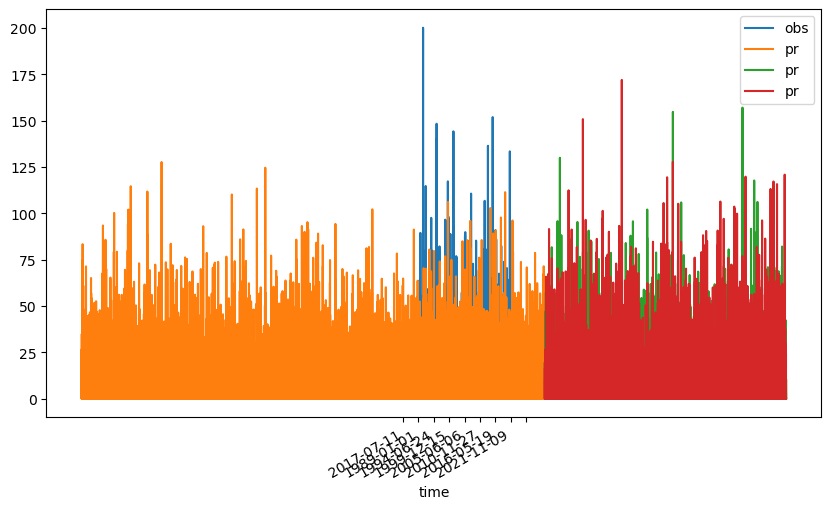

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))  # 设定图形大小

pr_obs.plot(ax=ax, label='obs')
loaded_data_dict['historical']['pr'].plot(ax=ax, label='historical')
loaded_data_dict['ssp245']['pr'].plot(ax=ax, label='ssp245')
loaded_data_dict['ssp585']['pr'].plot(ax=ax, label='ssp585')

plt.legend()
plt.show()

In [16]:
loaded_data_dict['historical']['pr'].max().round(2)

pr    127.74
dtype: float64

In [6]:
loaded_data_dict['ssp245']['pr'].max()

pr    157.109166
dtype: float64

In [7]:
loaded_data_dict['ssp585']['pr'].max()

pr    172.062917
dtype: float64

# 数据集划分

# Downscaling method

## DecisionTreeRegressor

In [5]:
# Choose a downscaling model
model = DecisionTreeRegressor()

# Train your model
model.fit(X_train, y_train)

# Evaluate your model
predictions = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R2 Score:', model.score(y_test, predictions))

NameError: name 'X_train' is not defined

## 支持向量机回归（SVR）

In [82]:
from sklearn.svm import SVR

# Choose a downscaling model
model = SVR()

# Train your model
model.fit(X_train, y_train.ravel())

# Evaluate your model
predictions = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R2 Score:', model.score(y_test, predictions))

Mean Squared Error: 1.1965752830322154
R2 Score: -0.8056337312620787


## 随机森林回归 （Random Forest Regression）

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Choose a downscaling model
model = RandomForestRegressor()

# Train your model
model.fit(X_train, y_train.ravel())

# Evaluate your model
predictions = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R2 Score:', model.score( y_test, predictions))

Mean Squared Error: 1.4608800130645283
R2 Score: -1.2986204936344348


## 梯度提升回归树 （Gradient Boosting Regression Tree）

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# Choose a downscaling model
model = GradientBoostingRegressor()

# Train your model
model.fit(X_train, y_train.ravel())

# Evaluate your model
predictions = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R2 Score:', model.score(y_test, predictions))

ValueError: Found input variables with inconsistent numbers of samples: [60264, 12418]

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
model = GradientBoostingRegressor()

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.ravel())

# Get the best parameters
best_params = grid_search.best_params_

# Train your model with the best parameters
model = GradientBoostingRegressor(**best_params)
model.fit(X_train, y_train.ravel())

# Evaluate your model
predictions = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R2 Score:', model.score(y_test,predictions))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators

## 神经网络

In [84]:
from sklearn.neural_network import MLPRegressor

# Choose a downscaling model
model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500)

# Train your model
model.fit(X_train, y_train.ravel())

# Evaluate your model
predictions = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('R2 Score:', model.score(y_test, predictions))

Mean Squared Error: 1.0655691274824677
R2 Score: -0.8092458343956421


# 特性验证

Predictions:
Mean: -0.0286433257481965
Median: -0.3406558074848177
Standard deviation: 0.9258918377573259
Actual values:
Mean: 0.030325047349057603
Median: -0.3415597558675498
Standard deviation: 1.0256616720312488
Kolmogorov-Smirnov test:
KS statistic: 0.02527646129541864
p-value: 0.579000218111953
Correlation: 0.012266167390796499


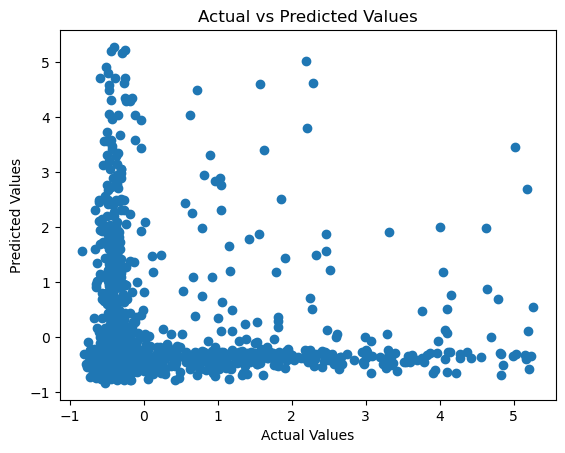

In [115]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculate descriptive statistics
print('Predictions:')
print('Mean:', predictions.mean())
print('Median:', np.median(predictions))
print('Standard deviation:', predictions.std())
print('Actual values:')
print('Mean:', y_test.mean())
print('Median:', np.median(y_test))
print('Standard deviation:', y_test.std())

# Perform a Kolmogorov-Smirnov test to compare the distributions
ks_statistic, p_value = stats.ks_2samp(predictions, y_test.ravel())
print('Kolmogorov-Smirnov test:')
print('KS statistic:', ks_statistic)
print('p-value:', p_value)

# Calculate the correlation
correlation = np.corrcoef(predictions, y_test.ravel())[0, 1]
print('Correlation:', correlation)

# Create a scatter plot
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

这张图使用的是DecisionTreeRegressor()模型，下面我将解读数据和图像含义：

1. Mean: 这是预测值和实际值的平均值。预测值的平均值为-0.0244，实际值的平均值为0.0340。这表明预测值的平均值略低于实际值。

2. Median: 这是预测值和实际值的中位数。预测值的中位数为-0.3418，实际值的中位数为-0.3416。这表明预测值的中位数和实际值的中位数非常接近。

3. Standard deviation: 这是预测值和实际值的标准差，用来衡量数据的离散程度。预测值的标准差为0.9328，实际值的标准差为1.0320。这表明预测值的离散程度略低于实际值。

4. KS statistic (Kolmogorov-Smirnov statistic): 这是一个用于比较两个概率分布的统计量。在你的情况下，它用于比较预测值和实际值的分布。KS statistic 的值为0.0242，这是一个相对较小的值，表明预测值和实际值的分布相对接近。

5. p-value: 这是一个统计假设检验的结果，用于判断观察到的数据与假设之间的差异是否显著。在你的情况下，p-value 是用于判断预测值和实际值的分布是否显著不同。p-value 为0.6333，大于0.05，这表明预测值和实际值的分布没有显著差异。

6. Correlation: 这是一个度量两个变量之间线性关系强度和方向的统计量。其值为0.0122，这表明预测值和实际值之间有微弱的正线性关系。

这个散点图显示了预测值（y轴）与实际值（x轴）的关系。点集中在左下角，贴近x轴和y轴的数据较多，这可能说明以下几点：

* 预测值和实际值都偏小：由于点集中在左下角，这表明大部分预测值和实际值都比较小。这可能是因为数据的分布是偏向较小值的，或者模型在预测较大值时的性能不佳。

* 预测值和实际值的范围相似：这说明预测值对于模拟实际值的分布是符合要求的。

# 所有变量处理

In [2]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv', index_col=0)

mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0)

# 创建一个字典来存储观察数据
obs_data = {
    'pr': fengqiao['precipitation'],
    'ps': mete['PS'],
    'tas': mete['T2M'],
    'tasmax': mete['T2M_MAX'],
    'tasmin': mete['T2M_MIN'],
}

# Load the entire dictionary from the pickle file
with open('../data/intermediate/data_dict.pkl', 'rb') as f:
    loaded_data_dict = pickle.load(f)

scenarios = ['historical', 'ssp245', 'ssp585']
variables = ['pr', 'ps', 'tas', 'tasmax', 'tasmin']

for scenario in scenarios:
    for variable in variables:
        # Determine the start and end dates of the current dataset
        start_date = loaded_data_dict[scenario][variable].index.min()
        end_date = loaded_data_dict[scenario][variable].index.max()

        # Create a new date range that includes all dates between the start and end dates
        new_index = pd.date_range(start=start_date, end=end_date)

        # Reindex the dataframe to include any missing dates
        loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable].reindex(new_index)

        # Interpolate to fill in the missing values
        loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable].interpolate()

        if variable == 'pr':
            loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable] * 86400 / 1000 *1000 
        elif variable == 'ps':
            loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable] / 1000
        else:  # 'tas', 'tasmax', 'tasmin'
            loaded_data_dict[scenario][variable] = loaded_data_dict[scenario][variable] - 273.15

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

def predict_scenario_variables(obs,historical,future, scenario, variable):
    obs.index = pd.to_datetime(obs.index)
    historical.index = pd.to_datetime(historical.index)
    obs_future = obs
    obs_future.index = pd.to_datetime(obs_future.index)
    future.index = pd.to_datetime(future.index)

    # Align the time scales
    start_date = max(obs.index.min(), historical.index.min())
    end_date = min(historical.index.max(), obs.index.max())
    obs = obs.loc[start_date:end_date]
    historical = historical.loc[start_date:end_date]

    # Future
    future_end_date = obs_future.index.max()
    future = future.loc[future_end_date:]
    
    # Split your historical data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(historical, obs, test_size=0.2, random_state=42)

    # Choose a downscaling model
    model = DecisionTreeRegressor()

    # Train your model
    model.fit(X_train, y_train)

    # Test predictions
    test_predictions = model.predict(X_test)
    test_predictions_df = pd.DataFrame(test_predictions, index=X_test.index)

    # Future predictions
    future_predictions = model.predict(future)
    future_predictions_df = pd.DataFrame(future_predictions, index=future.index)

    # Perform a Kolmogorov-Smirnov test to compare the distributions
    ks_statistic, p_value = stats.ks_2samp(test_predictions, y_test.ravel())

    # Calculate the correlation
    correlation = test_predictions_df.corrwith(y_test)[0]

    # Create a scatter plot
    plt.scatter(y_test, test_predictions_df)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values for ' + scenario + ' ' + variable)
    plt.savefig('../figures/' + scenario + '_' + variable + '.png')
    plt.close()

    print('Kolmogorov-Smirnov test:' + scenario + ' ' + variable)
    print('KS statistic:', ks_statistic)
    print('p-value:', p_value)
    print('Correlation:', correlation)

    return future_predictions_df

In [4]:
predictions_df = pd.DataFrame()

# 对 'ssp245' 和 'ssp585' 情景的变量进行预测
scenarios = ['ssp245', 'ssp585']
variables = ['pr', 'ps', 'tas', 'tasmax', 'tasmin']

for scenario in scenarios:
    for variable in variables:
        # 从字典中获取观察数据
        obs = obs_data[variable]

        # 从 loaded_data_dict 中获取历史数据和未来数据
        historical = loaded_data_dict['historical'][variable]
        future = loaded_data_dict[scenario][variable]

        # 调用函数进行预测
        future_predictions= predict_scenario_variables(obs, historical, future, scenario, variable)
        # 将预测结果添加到DataFrame中
        predictions_df[f'{scenario}_{variable}'] = future_predictions

Kolmogorov-Smirnov test:ssp245 pr
KS statistic: 0.07424960505529225
p-value: 5.640660944297534e-05
Correlation: -0.0021419345919209414
Kolmogorov-Smirnov test:ssp245 ps
KS statistic: 0.02843601895734597
p-value: 0.4264703979431698
Correlation: 0.5890990278388041
Kolmogorov-Smirnov test:ssp245 tas
KS statistic: 0.018957345971563982
p-value: 0.8846720453995729
Correlation: 0.8107362841826724
Kolmogorov-Smirnov test:ssp245 tasmax
KS statistic: 0.020537124802527645
p-value: 0.8182052509933021
Correlation: 0.7560276106936566
Kolmogorov-Smirnov test:ssp245 tasmin
KS statistic: 0.022116903633491312
p-value: 0.7418985614668319
Correlation: 0.7922607941267249
Kolmogorov-Smirnov test:ssp585 pr
KS statistic: 0.07424960505529225
p-value: 5.640660944297534e-05
Correlation: -0.0021419345919209414
Kolmogorov-Smirnov test:ssp585 ps
KS statistic: 0.02843601895734597
p-value: 0.4264703979431698
Correlation: 0.5890990278388041
Kolmogorov-Smirnov test:ssp585 tas
KS statistic: 0.018957345971563982
p-value:

In [5]:
predictions_df['ssp245_pr'].mean()

3.1474153353454386

您提供的数据包含了不同情景和变量在气候模型中的 Kolmogorov-Smirnov (KS) 测试结果和相关系数。KS 测试检查两个样本是否来自同一分布，而相关系数衡量预测值和实际值之间的线性关系。

对于每个情境和变量，都有一个 KS 统计量、KS 测试的 p 值和相关系数。让我们详细解读一下这些结果：

KS 统计量：这是一个介于 0 和 1 之间的数值，量化了两个样本的经验分布函数之间的距离。在这个情况下，两个样本分别是您的预测值和实际观察值。KS 统计量越小，两个样本拥有相同分布的可能性越大。

P 值：假设零假设成立，观察到与您得到的 KS 统计量一样极端或更极端的情况的概率。KS 测试的零假设是这两个样本来自同一分布。小的 p 值（通常低于 0.05）表明我们应该拒绝零假设，并得出这两个样本来自不同分布的结论。大的 p 值表明我们不能拒绝零假设，即两个样本可能合理地来自同一分布。

相关性：相关系数衡量预测值和实际值之间的线性关系。1 表示完全正相关，-1 表示完全负相关，0 表示无关联。

现在，让我们分析一下结果：

对于 'ssp245' 和 'ssp585' 的情景：

对于 'pr' 变量，KS 统计量相当高（0.074），而 p 值非常小（低于 0.05），这表明实际值和预测值的分布存在显著差异。此外，相关性接近零，意味着预测值和实际值之间没有明显的线性关系。

对于 'ps'、'tas'、'tasmax'、'tasmin' 变量，KS 统计量相对较低，且 p 值远高于 0.05。这表明预测值和实际值可能来自同一分布，即模型的预测与实际值相当一致。另外，相关系数相当高（都超过 0.5），表明预测值和实际值之间存在强正线性关系。

看起来您的模型在 'ps'、'tas'、'tasmax'、'tasmin' 变量上的表现良好，但在 'pr' 变量上的表现不佳。

pr的情况是因为降雨数据一般情况下为0，下雨情况存在随机性，无法预测长时间序列什么时候下雨，这就是为什么pr的相关性不高，但是KS表现还可以的原因。

In [7]:
predictions_df['ssp245_pr'].max()

6.256578860535411

In [6]:
predictions_df.round(2).to_csv('../data/intermediate/predictions_future.csv')